# Cell cycle score calculation

<b>This code is for the Cell cycle (S,G2/M), cell cycle progression (CCP), hypoxia,  mesenchymal and epithelial score calculation.</b><br>
In this analysis I am calculating score for above pathways by using common biomarker genes.<br>
This is basic methodology for cell cycles score by using Seurat, but I am using my own code.
https://hbctraining.github.io/scRNA-seq/lessons/cell_cycle_scoring.html <br>
https://satijalab.org/seurat/reference/cc.genes.updated.2019.html#source <br>
<b> Cell cycle </b> genes :: https://raw.githubusercontent.com/hbc/tinyatlas/master/cell_cycle/Mus_musculus.csv <br>
https://github.com/hbc/tinyatlas <br>
<b>Cell cycle progession (CCP) </b> score :: https://www.sciencedirect.com/science/article/pii/S1535610818305828?via%3Dihub<br>
<b>Hypoxia Biomaker</b> https:://www.sciencedirect.com/science/article/pii/S0936655515003118 <br>
<b>Stemness biomarker genes list </b>are available at www.pnas.org/cgi/doi/10.1073/pnas.1818210116 <br>

Omit genes below the median of average expression across samples Biranda et al. PNAS Stemness paper. At this point I didn't remove genes based on median expression cutoff. <br>
CCP manuscript also have Hypoxia score methodology, but I am not using that one.


## Global parameter

In [3]:
suppressMessages(suppressWarnings(library(dplyr)))
suppressMessages(suppressWarnings(library(rtracklayer)))
suppressMessages(suppressWarnings(library(edgeR)))
suppressMessages(suppressWarnings(library(limma)))

## Read GTF file

In [4]:
GTF="Mus_musculus.GRCm39.104.rdna_rn18s.gtf.gz"
GTF <- import(GTF)
gencode.vM27.gtf <- as.data.frame(GTF)
head(gencode.vM27.gtf)
colnames(gencode.vM27.gtf)

,seqnames,start,end,width,strand,source,type,score,phase,gene_id,...,transcript_source,transcript_biotype,tag,transcript_support_level,exon_number,exon_id,exon_version,protein_id,protein_version,ccds_id
,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,150956201,150958296,2096,+,havana,gene,NA,NA,ENSMUSG00000102628,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1,150956201,150958296,2096,+,havana,transcript,NA,NA,ENSMUSG00000102628,...,havana,TEC,basic,NA (assigned to previous version 1),NA,NA,NA,NA,NA,NA
3,1,150956201,150958296,2096,+,havana,exon,NA,NA,ENSMUSG00000102628,...,havana,TEC,basic,NA (assigned to previous version 1),1,ENSMUSE00001342333,2,NA,NA,NA
4,1,150983666,150984611,946,+,havana,gene,NA,NA,ENSMUSG00000100595,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,1,150983666,150984611,946,+,havana,transcript,NA,NA,ENSMUSG00000100595,...,havana,processed_pseudogene,basic,NA (assigned to previous version 1),NA,NA,NA,NA,NA,NA
6,1,150983666,150984611,946,+,havana,exon,NA,NA,ENSMUSG00000100595,...,havana,processed_pseudogene,basic,NA (assigned to previous version 1),1,ENSMUSE00001324949,2,NA,NA,NA


[1] "seqnames"                 "start"                   
 [3] "end"                      "width"                   
 [5] "strand"                   "source"                  
 [7] "type"                     "score"                   
 [9] "phase"                    "gene_id"                 
[11] "gene_version"             "gene_name"               
[13] "gene_source"              "gene_biotype"            
[15] "transcript_id"            "transcript_version"      
[17] "transcript_name"          "transcript_source"       
[19] "transcript_biotype"       "tag"                     
[21] "transcript_support_level" "exon_number"             
[23] "exon_id"                  "exon_version"            
[25] "protein_id"               "protein_version"         
[27] "ccds_id"

In [5]:
gene_lengths <- gencode.vM27.gtf %>%
  filter(type=="gene") %>%
  dplyr::rename(Chromosome= seqnames, Type= type, Geneid = gene_id, Class=gene_biotype, GeneSymbol= gene_name, Length=width, Start = start, End=end, Strand=strand) %>%
  select(Geneid, GeneSymbol, Chromosome, Start, End, Class,  Strand, Length) %>%
  filter(!grepl("chrM",Chromosome))

rownames(gene_lengths) <- gene_lengths$Geneid
head(gene_lengths)

,Geneid,GeneSymbol,Chromosome,Start,End,Class,Strand,Length
,<chr>,<chr>,<fct>,<int>,<int>,<chr>,<fct>,<int>
ENSMUSG00000102628,ENSMUSG00000102628,Gm37671,1,150956201,150958296,TEC,+,2096
ENSMUSG00000100595,ENSMUSG00000100595,Gm19087,1,150983666,150984611,processed_pseudogene,+,946
ENSMUSG00000097426,ENSMUSG00000097426,Gm8941,1,151012258,151013531,processed_pseudogene,+,1274
ENSMUSG00000104478,ENSMUSG00000104478,Gm38212,1,108344807,108347562,TEC,+,2756
ENSMUSG00000104385,ENSMUSG00000104385,Gm7449,1,6980784,6981446,processed_pseudogene,+,663
ENSMUSG00000086053,ENSMUSG00000086053,Gm15178,1,75368775,75373007,lncRNA,-,4233


## Gene expression

In [6]:
Exp <- read.table("blancgrp_211613_RNAseq_total_stranded_HTSeq.counts.raw.txt")

sampleTable <- factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3))
Exp <- as.data.frame(Exp)
head(Exp)

,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
__alignment_not_unique,0,0,0,0,0,0,0,0,0
__ambiguous,2560090,1985537,2111861,2173495,2588939,2547004,1475506,2456396,1492933
__no_feature,7214805,5557028,6265574,5430678,6721998,7243883,4780631,6372950,4928527
__not_aligned,108660468,83657393,91248863,86022491,99134745,117253539,75553198,101248621,67440141
rDNA_promoter,0,0,0,0,0,0,0,0,0
rDNA_promoter1,0,0,0,0,0,0,0,0,0


In [7]:
sampleTable <- data.frame(condition = factor(rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)))
rownames(sampleTable) <- colnames(Exp)
sampleTable

,condition
,<fct>
JBQS001,Control
JBQS002,Control
JBQS003,Control
JBQS004,TGFB
JBQS005,TGFB
JBQS006,TGFB
JBQS007,TGFb_CX5461
JBQS008,TGFb_CX5461
JBQS009,TGFb_CX5461


## Gene filtering

In [29]:
################## Filtering Step/remove probes #####################
Gene_filtering <- function(mat, Count_filter=0){
  not_all_na <- function(x) any(!is.na(x))
  mat <- mat %>%
    dplyr::select(where(not_all_na))
  mat <- subset(mat, apply(mat, 1, sum) != 0)
  #mat <- subset(mat, apply(mat, 2, sum) != 0)# not_all_na already did this
  mat <- mat[apply(mat,1,function(x) sum(x<=0))< ncol(mat)*0.75,]##Remove genes which have over 25% zero
  mat <- subset(mat, apply(mat, 1, sum) >= Count_filter)
  return(mat)}
counts <- Gene_filtering(mat = as.data.frame(Exp), Count_filter = 3)

In [9]:
dds <- DESeq2::DESeqDataSetFromMatrix(round(counts), sampleTable, ~condition)
dds <- estimateSizeFactors( dds )
#normalized_counts <- counts(dds, normalized=TRUE)
logcounts <- log2( counts(dds, normalized=TRUE) + 1 )

head(logcounts)

converting counts to integer mode



,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
__ambiguous,20.9741985,21.164356,21.001657,21.315922,20.918094,20.862762,21.031248,21.001354,20.697300
__no_feature,22.4689639,22.649140,22.570588,22.637038,22.294623,22.370723,22.727238,22.376772,22.420307
__not_aligned,26.3816866,26.561248,26.434876,26.622547,26.177052,26.387447,26.709458,26.366569,26.194686
__too_low_aQual,0.8517197,1.751603,0.000000,0.000000,1.339520,1.320386,2.421503,1.833359,2.142923
0610009B22Rik,5.4741486,5.966948,5.773086,5.782638,5.575478,5.798375,5.654854,6.251731,5.707315
0610009E02Rik,3.7943548,3.388093,3.692662,2.202653,1.339520,2.245898,2.767595,2.803613,2.142923


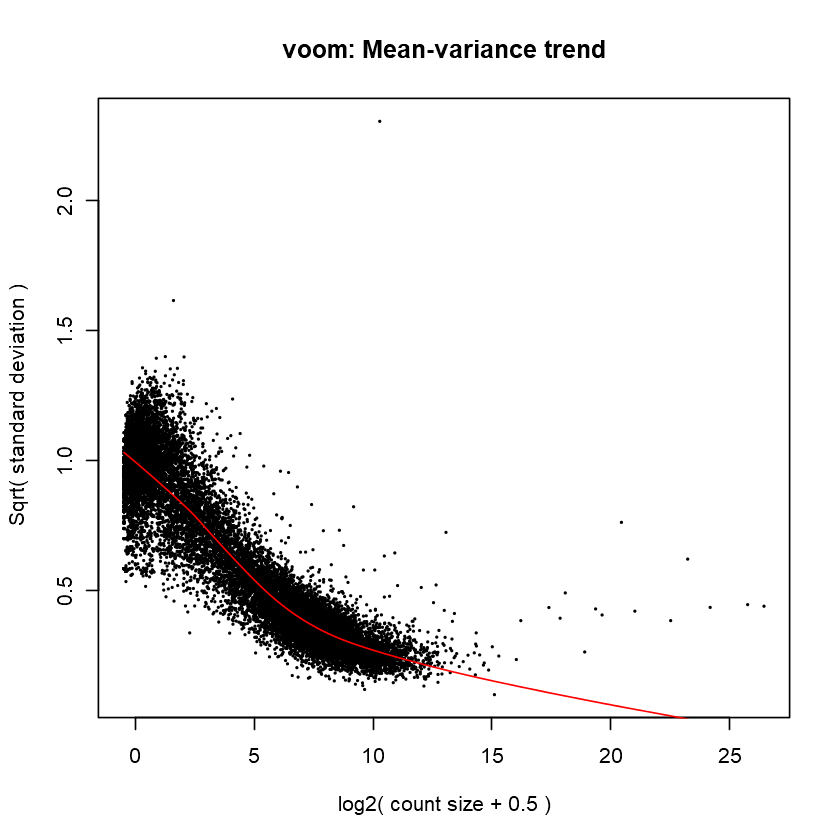

In [10]:
groupLabels <- rep(c("Control", "TGFB", "CX5461"), each = 3)
TS <- factor(groupLabels, levels = c("Control", "TGFB", "CX5461"))

design <- model.matrix(~ 0 + TS )
colnames(design) <- levels(TS)
dge <- DGEList(counts = Exp, group = groupLabels)

# filter out low expressed genes
cpm_cutoff=5; min.expr.counts=1; min.expr.num.samples=3

cutoff <- as.vector(cpm(cpm_cutoff,mean(dge$samples$lib.size) ) )
#keep <- rowSums(cpm(dge) > cutoff) >= min(as.numeric(table(groupLabels)))
keep <- rowSums(getCounts(dge) >= min.expr.counts)  >=  min.expr.num.samples
dge <- dge[keep, keep.lib.sizes = FALSE]
normMethod = "TMM"
dge <- calcNormFactors(dge, method=normMethod)
#getCounts(dge) #get expression matrix from 
v <- voom(dge, design, plot = T)
#logcounts <- v$E

In [30]:

Selected_Gene <- function(mat, geneLength){
  genes <- intersect(rownames(mat), geneLength$GeneSymbol)
  geneLength <- geneLength[geneLength$GeneSymbol %in% genes,]
  geneLength <- geneLength[!duplicated(geneLength$GeneSymbol),]
  mat <- as.data.frame(mat[genes,])
  return(list(Expression=mat, GeneLength=geneLength))}

#scale(log2(RSEM_FPKM+1), center = TRUE, scale = TRUE) ##https://medium.com/swlh/data-normalisation-with-r-6ef1d1947970
#exp.scaled <- (scale(log2(t(RSEM_FPKM+1)), center = TRUE, scale = TRUE))

#Selected_Gene_Exp <- Selected_Gene(mat = logcounts, geneLength = gene_lengths)
Selected_Gene_Exp <- Selected_Gene(mat = counts, geneLength = gene_lengths)
head(Selected_Gene_Exp$Expression)
head(Selected_Gene_Exp$GeneLength)
class(Selected_Gene_Exp$Expression)

,JBQS001,JBQS002,JBQS003,JBQS004,JBQS005,JBQS006,JBQS007,JBQS008,JBQS009
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0610009B22Rik,54,52,54,45,61,73,34,88,45
0610009E02Rik,16,8,12,3,2,5,4,7,3
0610009L18Rik,13,3,10,5,10,15,6,11,7
0610010F05Rik,142,107,112,106,198,217,80,128,131
0610010K14Rik,0,1,1,4,4,1,1,2,2
0610012G03Rik,201,155,173,150,214,230,136,200,139


,Geneid,GeneSymbol,Chromosome,Start,End,Class,Strand,Length
,<chr>,<chr>,<fct>,<int>,<int>,<chr>,<fct>,<int>
ENSMUSG00000100480,ENSMUSG00000100480,Gm29156,1,43784944,43785442,lncRNA,-,499
ENSMUSG00002076531,ENSMUSG00002076531,7SK,1,109732490,109732774,misc_RNA,+,285
ENSMUSG00000100025,ENSMUSG00000100025,Gm8141,1,109760754,109762476,processed_pseudogene,+,1723
ENSMUSG00002076687,ENSMUSG00002076687,U2,1,151136575,151136665,snRNA,-,91
ENSMUSG00000100954,ENSMUSG00000100954,Gm10138,1,151215355,151220982,lncRNA,-,5628
ENSMUSG00000051285,ENSMUSG00000051285,Pcmtd1,1,7159144,7243852,protein_coding,+,84709


[1] "data.frame"

## Biomakers genes list

In [12]:
# https://hbctraining.github.io/scRNA-seq/lessons/cell_cycle_scoring.html
mouse.cell.cycle <- read.csv("https://raw.githubusercontent.com/hbc/tinyatlas/master/cell_cycle/Mus_musculus.csv")
# www.pnas.org/cgi/doi/10.1073/pnas.1818210116 #Stemness marker
#https://satijalab.org/seurat/reference/cc.genes.updated.2019.html#source
#Seurat::cc.genes.updated.2019
#median(colMeans(logcounts)) ## omit genes below the median of average expression across samples Biranda et al. PNAS Stemness paper
cc.S <- mouse.cell.cycle[mouse.cell.cycle$phase=="S",]
cc.G2 <- mouse.cell.cycle[mouse.cell.cycle$phase=="G2/M",]
CCP_gene <- stringr::str_to_sentence(c("PLK1", "RRM2", "CDCA8", "CDC20", "CDCA3", "FOXM1", "BIRC5", "PBK", "CDKN3", "CENPM", "MCM10", "TK1", "DTL", "ASF1B", "NUSAP1", "PRC1", "BUB1B", "DLGAP5", "TOP2A", "ASPM", "CENPF", "KIF20A", "PTTG1", "RAD54L", "ORC6", "CDK1", "CEP55", "KIF11", "RAD51", "KIAA0101", "SKA1"))
Housekeeping_gene <- stringr::str_to_sentence(c("RPL38", "UBA52", "PSMC1", "RPL4", "RPL37", "RPS29", "SLC25A3", "CLTC", "TXNL1", "PSMA1", "RPL8", "MMADHC", "RPL13A", "PPP2CA", "MRFAP1"))
Hypoxia_Gene <- stringr::str_to_sentence(c("BNIP3", "F3", "LOX", "TNF", "TH", "SLC2A1", "PGK1", "NDRG1", "GAL", "BNIP3L", "ANG", "P4HA1", "ADM", "AK3", "PDK1", "ERO1L", "ALDOC", "PLOD2", "P4HA2", "MXI1", "DDIT4", "ANGPTL4"))
Mesenchymal_Gene <- stringr::str_to_sentence(c("VIM", "CDH2", "FOXC2", "SNAI1", "SNAI2", "TWIST1", "FN1", "ITGB6", "MMP2", "MMP3", "MMP9", "SOX10", "GCS"))
Epithelial_Gene <- stringr::str_to_sentence(c("CDH1", "DSP", "OCLN"))
STEM_Gene <- stringr::str_to_sentence(c("DNMT3B", "PFAS", "XRCC5", "HAUS6", "TET1", "IGF2BP1", "PLAA", "TEX10", "MSH6", "DLGAP5", "SKIV2L2", "SOHLH2", "RRAS2", "PAICS", "CPSF3", "LIN28B", "IPO5", "BMPR1A", "ZNF788", "ASCC3", "FANCB", "HMGA2", "TRIM24", "ORC1", "HDAC2", "HESX1", "INHBE", "MIS18A", "DCUN1D5", "MRPL3", "CENPH", "MYCN", "HAUS1", "GDF3", "TBCE", "RIOK2", "BCKDHB", "RAD1", "NREP", "ADH5", "PLRG1", "ROR1", "RAB3B", "DIAPH3", "GNL2", "FGF2", "NMNAT2", "KIF20A", "CENPI", "DDX1", "XXYLT1", "GPR176", "BBS9", "C14orf166", "BOD1", "CDC123", "SNRPD3", "FAM118B", "DPH3", "EIF2B3", "RPF2", "APLP1", "DACT1", "PDHB", "C14orf119", "DTD1", "SAMM50", "CCL26", "MED20", "UTP6", "RARS2", "ARMCX2", "RARS", "MTHFD2", "DHX15", "HTR7", "MTHFD1L", "ARMC9", "XPOT", "IARS", "HDX", "ACTRT3", "ERCC2", "TBC1D16", "GARS", "KIF7", "UBE2K", "SLC25A3", "ICMT", "UGGT2", "ATP11C", "SLC24A1", "EIF2AK4", "GPX8", "ALX1", "OSTC", "TRPC4", "HAS2", "FZD2", "TRNT1", "MMADHC", "SNX8", "CDH6", "HAT1", "SEC11A", "DIMT1", "TM2D2", "FST", "GBE1"))

## Pathways score calculation

In [45]:
S_Score <- Selected_Gene_Exp$Expression %>% filter(Selected_Gene_Exp$GeneLength$Geneid %in% cc.S$geneID) %>% select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)
G2M_Score <- Selected_Gene_Exp$Expression %>% filter(Selected_Gene_Exp$GeneLength$Geneid %in% cc.G2$geneID) %>% select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)
CCP <- Selected_Gene_Exp$Expression %>% filter(Selected_Gene_Exp$GeneLength$GeneSymbol %in% CCP_gene) %>% select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)
Housekeeping_Score <- Selected_Gene_Exp$Expression %>% filter(Selected_Gene_Exp$GeneLength$GeneSymbol %in% Housekeeping_gene) %>% select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)
Hypoxia_Score <- Selected_Gene_Exp$Expression %>% filter(Selected_Gene_Exp$GeneLength$GeneSymbol %in% Hypoxia_Gene) %>% select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)
Mesenchymal_Score <- Selected_Gene_Exp$Expression %>% filter(Selected_Gene_Exp$GeneLength$GeneSymbol %in% Mesenchymal_Gene) %>% select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)
Epithelial_Score <- Selected_Gene_Exp$Expression %>% filter(Selected_Gene_Exp$GeneLength$GeneSymbol %in% Epithelial_Gene) %>% select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)

Score_Total <- as.data.frame(t(rbind(S_Score, G2M_Score, CCP, Housekeeping_Score, Hypoxia_Score, Mesenchymal_Score, Epithelial_Score)))

In [46]:
Score_Total

S_Score,G2M_Score,CCP,Housekeeping_Score,Hypoxia_Score,Mesenchymal_Score,Epithelial_Score
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
55,79.5,92.0,118,93,150.0,95
35,55.5,61.5,73,72,101.5,64
50,68.0,71.5,98,79,110.5,71
43,45.0,41.0,89,21,88.5,59
63,96.5,94.0,127,47,156.0,92
76,83.5,89.0,118,57,141.0,75
39,47.0,47.0,80,17,51.5,67
62,89.5,78.5,124,32,106.0,75
46,57.0,51.5,94,34,73.5,64


In [37]:
Score_Total <- Score_Total %>%
  select(everything()) %>%
  mutate(EMT_Score=scales::rescale(Mesenchymal_Score-Epithelial_Score, to = c(0.1,1)), 
         CCP_Score=scales::rescale(CCP-Housekeeping_Score, to=c(0.1,1)), 
         S_Score=scales::rescale(S_Score, to = c(0.1,1)),
         G2M_Score=scales::rescale(G2M_Score, to = c(0.1,1)),
         Hypoxia_Score=scales::rescale(Hypoxia_Score, to = c(0.1,1)),
         Sample=rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)) %>%
  select(c("Sample","EMT_Score","CCP_Score","S_Score","G2M_Score", "Hypoxia_Score"), everything())

## Save score in CSV files
#Score_Total %>% 
#  mutate(Scaled_EMT=scales::rescale(Score_Total$EMT_Score, to = c(0,1)))
#write.csv(Score_Total, file = "EMT_Score_File.csv")

In [49]:
#G2M_Score=G2M_Score-Housekeeping_Score
#S_Score=S_Score-Housekeeping_Score
Mesenchymal_Score=Mesenchymal_Score-Housekeeping_Score
Epithelial_Score=Epithelial_Score-Housekeeping_Score
Score_Total <- Score_Total %>%
  select(everything()) %>%
  mutate(EMT_Score=Mesenchymal_Score-Epithelial_Score, 
         CCP_Score=CCP-Housekeeping_Score, 
         S_Score=S_Score-Housekeeping_Score,
         G2M_Score=G2M_Score-Housekeeping_Score,
         Hypoxia_Score=Hypoxia_Score-Housekeeping_Score,
         Sample=rep(c("Control", "TGFB", "TGFb_CX5461"), each = 3)) %>%
  select(c("Sample","EMT_Score","CCP_Score","S_Score","G2M_Score", "Hypoxia_Score"), everything())

ERROR: Error in colMeans(x, na.rm = TRUE): 'x' must be numeric


In [48]:
Score_Total

Sample,EMT_Score,CCP_Score,S_Score,G2M_Score,Hypoxia_Score,CCP,Housekeeping_Score,Mesenchymal_Score,Epithelial_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Control,55.0,-26.0,-63,-38.5,-25,92.0,118,150.0,95
Control,37.5,-11.5,-38,-17.5,-1,61.5,73,101.5,64
Control,39.5,-26.5,-48,-30.0,-19,71.5,98,110.5,71
TGFB,29.5,-48.0,-46,-44.0,-68,41.0,89,88.5,59
TGFB,64.0,-33.0,-64,-30.5,-80,94.0,127,156.0,92
TGFB,66.0,-29.0,-42,-34.5,-61,89.0,118,141.0,75
TGFb_CX5461,-15.5,-33.0,-41,-33.0,-63,47.0,80,51.5,67
TGFb_CX5461,31.0,-45.5,-62,-34.5,-92,78.5,124,106.0,75
TGFb_CX5461,9.5,-42.5,-48,-37.0,-60,51.5,94,73.5,64


### Heatmap based on EMT gene's expression level

In [35]:
Exp.EMT <- Exp[stringr::str_to_sentence(c("VIM", "CDH2", "FOXC2", "SNAI1", "SNAI2", "TWIST1", "FN1", "ITGB6", "MMP2", "MMP3", "MMP9", "SOX10", "GCS", "CDH1", "DSP", "OCLN")),]

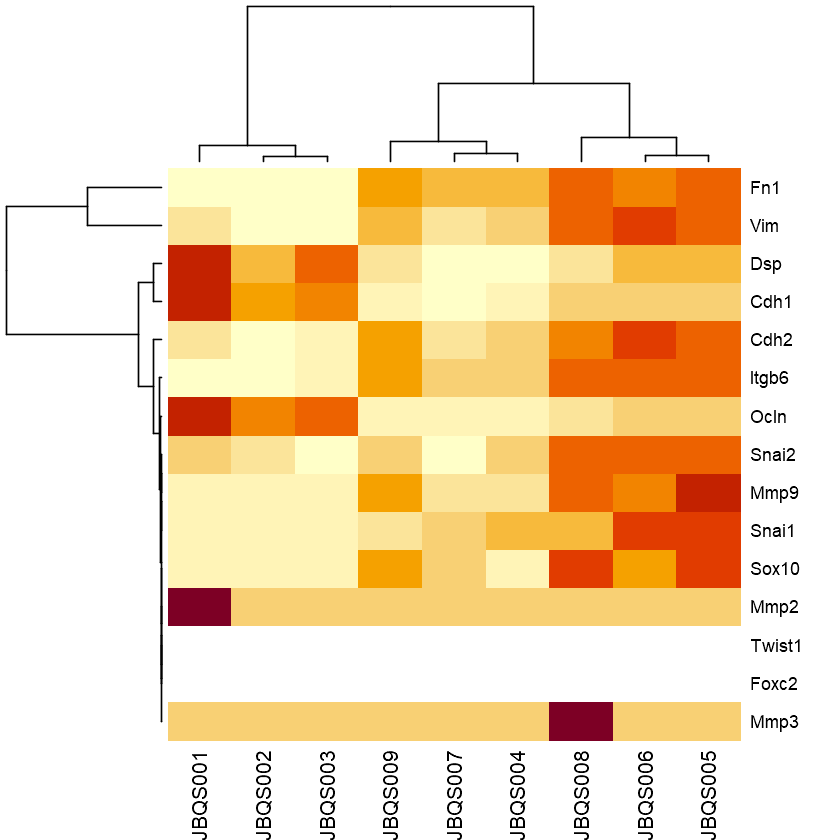

In [36]:
Exp.EMT <- na.omit(Exp.EMT)
heatmap(as.matrix(Exp.EMT), scale = "row")

In [50]:
Selected_Gene_Exp$Expression %>% filter(Selected_Gene_Exp$GeneLength$Geneid %in% cc.S$geneID) %>% select(everything()) %>% as.matrix() %>% matrixStats::colMedians(na.rm = TRUE)

[1] 55 35 50 43 63 76 39 62 46

In [54]:
class(Selected_Gene_Exp$GeneLength)

[1] "data.frame"